In [1]:
!pip install -U datasets tiktoken tqdm numpy torch
!pip install matplotlib

import os
import math
import time
from contextlib import nullcontext
from dataclasses import dataclass
from tqdm.auto import tqdm

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LambdaLR

import tiktoken
from datasets import load_dataset

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Check for Flash Attention (PyTorch 2.0+)
flash_available = hasattr(F, 'scaled_dot_product_attention')
print(f"Flash Attention (scaled_dot_product_attention) available: {flash_available}")

/home/namit/slm/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.9.0+cu128
CUDA available: True
CUDA version: 12.8
Current device: 0
Device name: NVIDIA GeForce RTX 3050 Laptop GPU
Flash Attention (scaled_dot_product_attention) available: True


In [ ]:
@dataclass
class SLMConfig:
    
    block_size: int = 128
    vocab_size: int = 50257
    n_layer: int = 6
    n_head: int = 6
    n_embd: int = 384
    dropout: float = 0.1
    bias: bool = False 
    
    batch_size: int = 32
    max_iters: int = 10000
    eval_interval: int = 500
    eval_iters: int = 200
    learning_rate: float = 1e-4
    weight_decay: float = 0.1
    beta1: float = 0.9
    beta2: float = 0.95
    grad_clip: float = 1.0
    
    warmup_iters: int = 1000
    lr_decay_iters: int = max_iters 
    min_lr: float = 1e-5

    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    dtype: str = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
    compile: bool = True
    
    num_proc: int = 8 
    total_batches: int = 1024 
    
    out_dir: str = 'out'
    best_model_name: str = 'best_model.pt'

config = SLMConfig()

config.lr_decay_iters = config.max_iters
os.makedirs(config.out_dir, exist_ok=True)
best_model_path = os.path.join(config.out_dir, config.best_model_name)

ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[config.dtype]
torch.set_default_dtype(ptdtype) 

print(f"Using device: {config.device}")
print(f"Using dtype: {config.dtype}")
print(f"Using PyTorch dtype: {ptdtype}")

Using device: cuda
Using dtype: bfloat16
Using PyTorch dtype: torch.bfloat16


In [ ]:

df = load_dataset("roneneldan/TinyStories")
encoding = tiktoken.get_encoding("gpt2")
if encoding.n_vocab != config.vocab_size:
    print(f"Warning: Tokenizer vocab size {encoding.n_vocab} != config vocab size {config.vocab_size}")
    config.vocab_size = encoding.n_vocab
    print(f"Updated config.vocab_size to {config.vocab_size}")

def processing(sample):
    ids = encoding.encode_ordinary(sample['text'])
    ids.append(encoding.eot_token) 
    out = {'ids': ids, 'len': len(ids)}
    return out
data_dir = os.path.join(os.getcwd(), 'data')
os.makedirs(data_dir, exist_ok=True)

for split in ['train', 'validation']:
    filename = os.path.join(data_dir, f'{split}.bin')
    
    if os.path.exists(filename):
        print(f"{filename} already exists. Skipping tokenization.")
        continue

    print(f"Tokenizing split: {split}...")
    tokenized = df[split].map(
        processing,
        remove_columns=['text'],
        desc=f"Tokenizing {split} split",
        num_proc=config.num_proc,
    )

    arr_len = np.sum(tokenized['len'], dtype=np.uint64)
    dtype = np.uint16 
    arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
    total_batches = config.total_batches
    
    print(f"Writing {arr_len} tokens to {filename}...")
    idx = 0
    for batch_idx in tqdm(range(total_batches), desc=f'Writing {filename}'):
        batch = tokenized.shard(
            num_shards=total_batches, 
            index=batch_idx, 
            contiguous=True
        ).with_format('numpy')
        
        arr_batch = np.concatenate(batch['ids'])
        arr[idx : idx + len(arr_batch)] = arr_batch
        idx += len(arr_batch)
    
    arr.flush()
    print(f"Finished writing {filename}.")

Loading TinyStories dataset...
Dataset loaded: DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2119719
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 21990
    })
})
Initializing GPT-2 tokenizer...
Tokenizing split: train...


Tokenizing train split (num_proc=8): 100%|██████████| 2119719/2119719 [00:34<00:00, 60606.58 examples/s]


Writing 473992236 tokens to /home/namit/slm/data/train.bin...


Writing /home/namit/slm/data/train.bin: 100%|██████████| 1024/1024 [05:36<00:00,  3.04it/s]


Finished writing /home/namit/slm/data/train.bin.
Tokenizing split: validation...


Tokenizing validation split (num_proc=8): 100%|██████████| 21990/21990 [00:00<00:00, 32472.03 examples/s]


Writing 4765918 tokens to /home/namit/slm/data/validation.bin...


Writing /home/namit/slm/data/validation.bin: 100%|██████████| 1024/1024 [00:04<00:00, 218.00it/s]

Finished writing /home/namit/slm/data/validation.bin.
Data tokenization complete.


In [ ]:
class BinDataset(Dataset):
    def __init__(self, data_file, block_size):
        super().__init__()
        self.block_size = block_size
        print(f"Loading data from {data_file}...")
        self.data = np.memmap(data_file, dtype=np.uint16, mode='r')
        self.length = len(self.data)
        self.num_chunks = (self.length - 1) // self.block_size
        print(f"Loaded {self.length} tokens.")
        print(f"Block size: {self.block_size}")
        print(f"Number of chunks: {self.num_chunks}")
    def __len__(self):
        return self.num_chunks
    def __getitem__(self, idx):
        start_idx = idx * self.block_size
        chunk = self.data[start_idx : start_idx + self.block_size + 1]
        chunk = torch.from_numpy(chunk.astype(np.int64))
        x = chunk[:-1]
        y = chunk[1:]
        return x, y
train_data_file = os.path.join(data_dir, 'train.bin')
val_data_file = os.path.join(data_dir, 'validation.bin')

train_dataset = BinDataset(train_data_file, config.block_size)
val_dataset = BinDataset(val_data_file, config.block_size)
cpu_generator = torch.Generator(device='cpu')

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=2,
    generator=cpu_generator
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    pin_memory=True,
    num_workers=2,
    generator=cpu_generator
)
x_batch, y_batch = next(iter(train_loader))
print(f"x_batch shape: {x_batch.shape}")
print(f"y_batch shape: {y_batch.shape}")
print(f"x_batch dtype: {x_batch.dtype}")
print(f"Device of batch: {x_batch.device}")

Loading data from /home/namit/slm/data/train.bin...
Loaded 473992236 tokens.
Block size: 128
Number of chunks: 3703064
Loading data from /home/namit/slm/data/validation.bin...
Loaded 4765918 tokens.
Block size: 128
Number of chunks: 37233

Testing the DataLoader...
x_batch shape: torch.Size([32, 128])
y_batch shape: torch.Size([32, 128])
x_batch dtype: torch.int64
Device of batch: cpu


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[config.dtype]
ctx = nullcontext() if config.device == 'cpu' else torch.amp.autocast(device_type=config.device, dtype=ptdtype)

class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            print("flash attention 2.0 not available")
            # causal mask
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))
    def forward(self, x):
        B, T, C = x.size()
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None,
                                               dropout_p=self.dropout if self.training else 0.0,
                                               is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))
        print(f"Model created. Number of parameters: {self.get_num_params()/1e6:.2f}M")
    def get_num_params(self, non_embedding=True):
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        if t > self.config.block_size:
            raise ValueError(f"Cannot forward sequence of length {t}, block size is {self.config.block_size}")
        pos = torch.arange(0, t, dtype=torch.long, device=device)
        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            logits = self.lm_head(x[:, [-1], :])
            loss = None
        return logits, loss
    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        idx = idx.to(self.config.device)
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
print("Initializing model...")
model = GPT(config)
print(f"Moving model to device: {config.device}")
model.to(config.device)
if config.compile:
    print("Compiling the model... (this may take a minute)")
    model = torch.compile(model)

Initializing model...
Model created. Number of parameters: 29.92M
Moving model to device: cuda
Compiling the model... (this may take a minute)
Model compiled.

Model setup complete.


In [ ]:
decay_params = []
no_decay_params = []
for pn, p in model.named_parameters():
    if p.dim() >= 2:
        decay_params.append(p)
    else:
        no_decay_params.append(p)
param_groups = [
    {'params': decay_params, 'weight_decay': config.weight_decay},
    {'params': no_decay_params, 'weight_decay': 0.0}
]
optimizer = torch.optim.AdamW(
    param_groups,
    lr=config.learning_rate,
    betas=(config.beta1, config.beta2),
    eps=1e-8
)
def get_lr_multiplier(it):
    if it < config.warmup_iters:
        return it / config.warmup_iters
    if it > config.lr_decay_iters:
        return config.min_lr / config.learning_rate
    decay_ratio = (it - config.warmup_iters) / (config.lr_decay_iters - config.warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    multiplier = (config.min_lr + coeff * (config.learning_rate - config.min_lr)) / config.learning_rate
    return multiplier
lr_scheduler = LambdaLR(optimizer, lr_lambda=get_lr_multiplier)

Setting up AdamW optimizer...
Setting up LR scheduler (linear warmup + cosine decay)...
Optimizer and LR Scheduler are ready.


In [ ]:
@torch.no_grad()
def estimate_loss(model, train_loader, val_loader, eval_iters, device, ctx):
    out = {}
    model.eval()
    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = torch.zeros(eval_iters)
        loader_iter = iter(loader)
        for k in range(eval_iters):
            try:
                X, Y = next(loader_iter)
            except StopIteration:
                loader_iter = iter(loader)
                X, Y = next(loader_iter)
            X, Y = X.to(device, non_blocking=True), Y.to(device, non_blocking=True)
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[config.dtype]
ctx = nullcontext() if config.device == 'cpu' else torch.amp.autocast(device_type=config.device, dtype=ptdtype)
initial_losses = estimate_loss(model, train_loader, val_loader, config.eval_iters, config.device, ctx)
print(f"Initial losses: {initial_losses}")

Estimating initial loss (this may take a moment)...
Initial losses: {'train': tensor(10.8750), 'val': tensor(10.8750)}


In [ ]:
import torch.amp 
import matplotlib.pyplot as plt
train_iter = iter(train_loader)
scaler = torch.amp.GradScaler(enabled=(config.dtype == 'float16'))
best_val_loss = float('inf')
train_loss_list = []
val_loss_list = []
print(f"Starting training for {config.max_iters} iterations...")
start_time = time.time()
for it in range(config.max_iters):
    if it % config.eval_interval == 0 or it == config.max_iters - 1:
        losses = estimate_loss(model, train_loader, val_loader, config.eval_iters, config.device, ctx)
        current_time = time.time()
        elapsed_time = current_time - start_time
        print(f"Step {it:6d} | Train Loss: {losses['train']:.4f} | Val Loss: {losses['val']:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f} | Time: {elapsed_time:.2f}s")
        train_loss_list.append(losses['train'].item())
        val_loss_list.append(losses['val'].item())
        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            if it > 0:
                checkpoint = {
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'config': config,
                    'iter': it,
                    'best_val_loss': best_val_loss
                }
                print(f"  -> New best val loss: {best_val_loss:.4f}. Saving checkpoint to {best_model_path}")
                torch.save(checkpoint, best_model_path)
    try:
        X, Y = next(train_iter)
    except StopIteration:
        train_iter = iter(train_loader)
        X, Y = next(train_iter)
    X, Y = X.to(config.device, non_blocking=True), Y.to(config.device, non_blocking=True)
    with ctx:
        logits, loss = model(X, Y)
    scaler.scale(loss).backward()
    if config.grad_clip > 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)
    scaler.step(optimizer)
    scaler.update()
    optimizer.zero_grad(set_to_none=True)
    lr_scheduler.step()
end_time = time.time()
print("\n--- Training Complete ---")
print(f"Total training time: {(end_time - start_time)/60:.2f} minutes")
print(f"Best validation loss: {best_val_loss:.4f}")

Starting training for 10000 iterations...
Step      0 | Train Loss: 10.8750 | Val Loss: 10.8750 | LR: 0.000000 | Time: 11.65s
Step    500 | Train Loss: 6.7500 | Val Loss: 6.7812 | LR: 0.000050 | Time: 73.80s
  -> New best val loss: 6.7812. Saving checkpoint to out/best_model.pt
Step   1000 | Train Loss: 4.2812 | Val Loss: 4.3125 | LR: 0.000100 | Time: 142.33s
  -> New best val loss: 4.3125. Saving checkpoint to out/best_model.pt
Step   1500 | Train Loss: 3.8125 | Val Loss: 3.8750 | LR: 0.000099 | Time: 216.25s
  -> New best val loss: 3.8750. Saving checkpoint to out/best_model.pt
Step   2000 | Train Loss: 3.6250 | Val Loss: 3.6719 | LR: 0.000097 | Time: 318.38s
  -> New best val loss: 3.6719. Saving checkpoint to out/best_model.pt
Step   2500 | Train Loss: 3.5156 | Val Loss: 3.5625 | LR: 0.000094 | Time: 458.72s
  -> New best val loss: 3.5625. Saving checkpoint to out/best_model.pt
Step   3000 | Train Loss: 3.4375 | Val Loss: 3.4844 | LR: 0.000089 | Time: 626.02s
  -> New best val loss

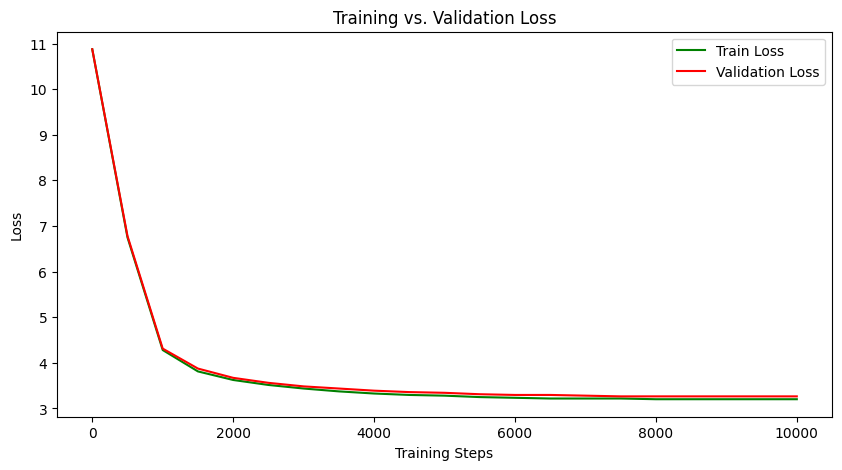

In [ ]:
import matplotlib.pyplot as plt
steps = [i * config.eval_interval for i in range(len(train_loss_list))]
plt.figure(figsize=(10, 5))
plt.plot(steps, train_loss_list, 'g', label='Train Loss')
plt.plot(steps, val_loss_list, 'r', label='Validation Loss')
plt.xlabel(f"Training Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs. Validation Loss")
plt.show()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [ ]:
checkpoint = torch.load(best_model_path, map_location=config.device, weights_only=False)
saved_config = checkpoint['config']
model = GPT(saved_config)
state_dict = checkpoint['model']
uncompiled_state_dict = {k[len('_orig_mod.'):] if k.startswith('_orig_mod.') else k: v for k, v in state_dict.items()}
model.load_state_dict(uncompiled_state_dict)
model.to(config.device)
model.eval()
if config.compile:
    print("Compiling the loaded model...")
    model = torch.compile(model)
sentence = "Once upon a time there was a girl."
context = torch.tensor(encoding.encode_ordinary(sentence), dtype=torch.long, device=config.device).unsqueeze(0)
print(f"Prompt: \"{sentence}\"")
print("-" * 20)
with torch.inference_mode():
    with ctx:
        y = model.generate(context, max_new_tokens=200, temperature=0.8, top_k=20)
print(encoding.decode(y.squeeze().tolist()))
print("-" * 20)
sentence = "A little girl went to the woods"
context = torch.tensor(encoding.encode_ordinary(sentence), dtype=torch.long, device=config.device).unsqueeze(0)

print(f"Prompt: \"{sentence}\"")
print("-" * 20)

with torch.inference_mode():
    with ctx:
        y = model.generate(context, max_new_tokens=200, temperature=0.8, top_k=20)

print(encoding.decode(y.squeeze().tolist()))
print("-" * 20)

Loading best model from out/best_model.pt...
Model created. Number of parameters: 29.92M
Compiling the loaded model...
Model loaded and ready for generation.

Generating text 1...
Prompt: "Once upon a time there was a girl."
--------------------
Once upon a time there was a girl. She was very sad but she couldn't see.

When she was walking. She saw a big, big box, and was so sad. As she looked around, she heard a big tree. It was a tree that was so big. She started to go away. It got the big and went up to the water. She was so happy to find the box. She put the rock back on her. She looked around and and saw a big, big box. It was bright and big and shiny.

The rabbit was so happy to have a new friend. She felt so happy and proud. She had a new toy that would be happy and always make the ball feel better.<|endoftext|>Once upon a time, there was a little girl named Lily. She was very happy. She loved to play outside in the park. One day, they saw a big, beautiful bird. The tree was sca

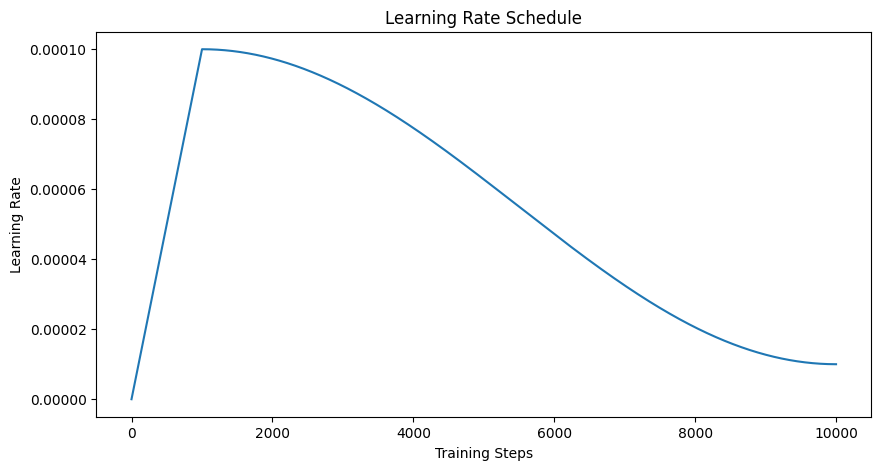

In [ ]:
def get_lr_multiplier(it):
    if it < config.warmup_iters:
        return it / config.warmup_iters 
    if it > config.lr_decay_iters:
        return config.min_lr / config.learning_rate
    decay_ratio = (it - config.warmup_iters) / (config.lr_decay_iters - config.warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    multiplier = (config.min_lr + coeff * (config.learning_rate - config.min_lr)) / config.learning_rate
    return multiplier
lrs = []
for it in range(config.max_iters):
    lr_multiplier = get_lr_multiplier(it)
    lrs.append(config.learning_rate * lr_multiplier)
plt.figure(figsize=(10, 5))
plt.plot(lrs)
plt.title("Learning Rate Schedule")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.show()

Plotting weight histograms...


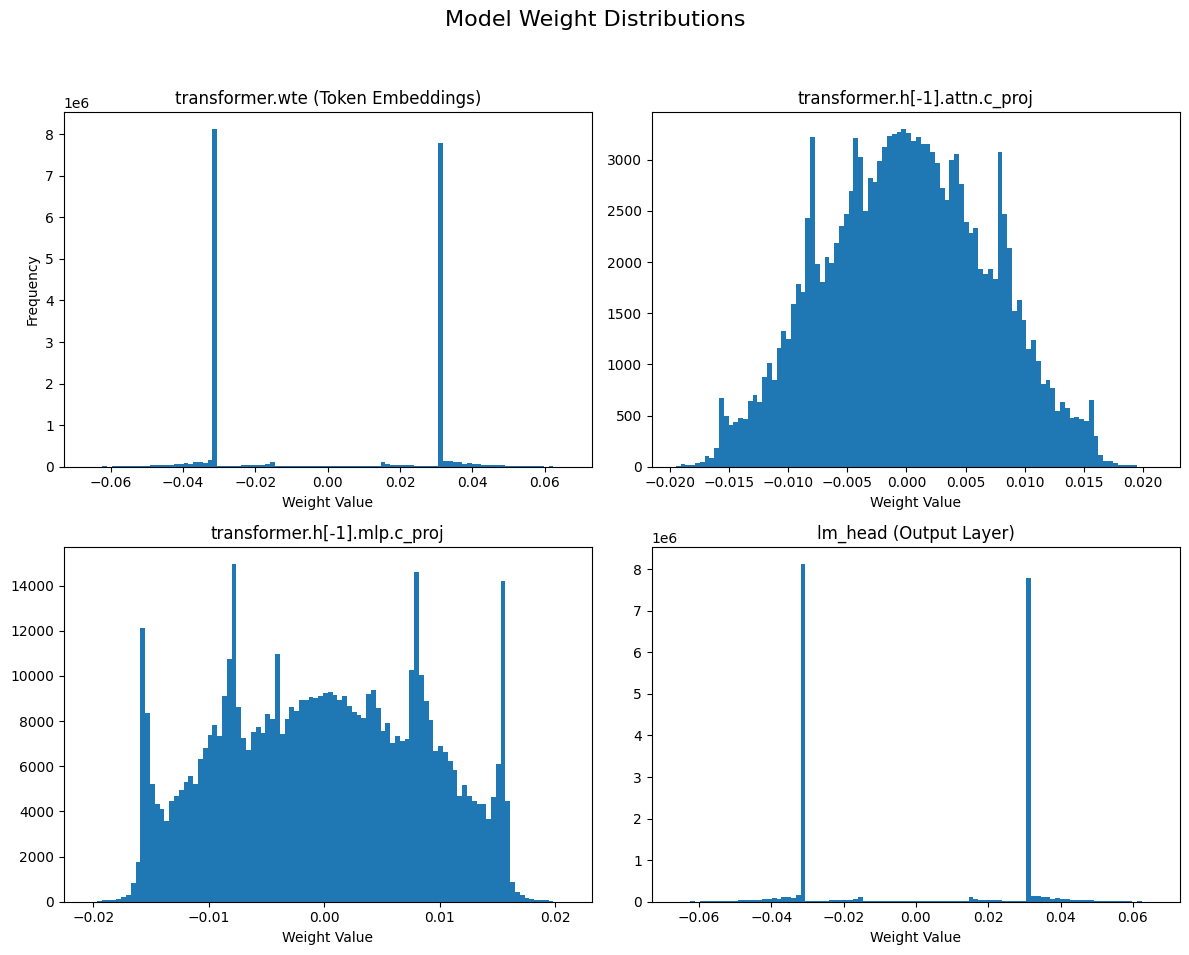

In [ ]:
model.eval()
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Model Weight Distributions', fontsize=16)

weights_wte = model.transformer.wte.weight.detach().cpu().float().numpy()
axs[0, 0].hist(weights_wte.flatten(), bins=100)
axs[0, 0].set_title("transformer.wte (Token Embeddings)")
axs[0, 0].set_xlabel("Weight Value")
axs[0, 0].set_ylabel("Frequency")

weights_attn = model.transformer.h[-1].attn.c_proj.weight.detach().cpu().float().numpy()
axs[0, 1].hist(weights_attn.flatten(), bins=100)
axs[0, 1].set_title("transformer.h[-1].attn.c_proj")
axs[0, 1].set_xlabel("Weight Value")
weights_mlp = model.transformer.h[-1].mlp.c_proj.weight.detach().cpu().float().numpy()
axs[1, 0].hist(weights_mlp.flatten(), bins=100)
axs[1, 0].set_title("transformer.h[-1].mlp.c_proj")
axs[1, 0].set_xlabel("Weight Value")

weights_lmhead = model.lm_head.weight.detach().cpu().float().numpy()
axs[1, 1].hist(weights_lmhead.flatten(), bins=100)
axs[1, 1].set_title("lm_head (Output Layer)")
axs[1, 1].set_xlabel("Weight Value")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Visualizing Attention Head...
Temporarily disabled Flash Attention for one layer to capture scores.


/home/namit/slm/.venv/lib/python3.13/site-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(


Hook removed and Flash Attention restored.


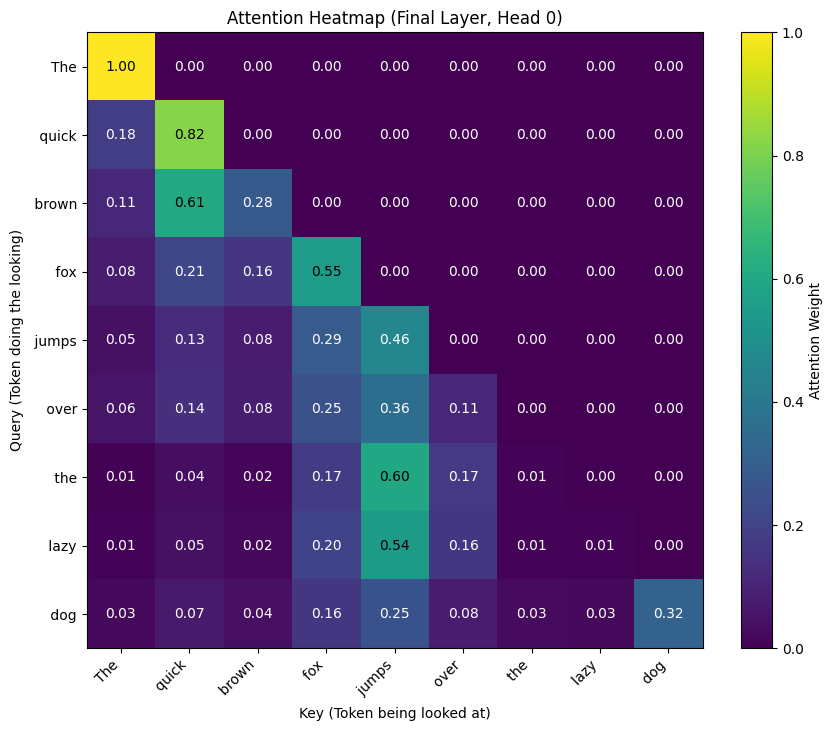

In [ ]:
attention_storage = {}

def save_attention_hook(module, input, output):
    attention_storage['attn_matrix'] = output

final_attn_block = model.transformer.h[-1].attn
hook_handle = final_attn_block.attn_dropout.register_forward_hook(save_attention_hook)
original_flash_setting = final_attn_block.flash
final_attn_block.flash = False
sentence = "The quick brown fox jumps over the lazy dog"
tokens = encoding.encode_ordinary(sentence)
token_tensor = torch.tensor(tokens, dtype=torch.long, device=config.device).unsqueeze(0)
model.eval()
with torch.inference_mode():
    with ctx:
        logits, loss = model(token_tensor, targets=token_tensor)
attn_matrix = attention_storage['attn_matrix'].cpu()
hook_handle.remove()
final_attn_block.flash = original_flash_setting
print("Hook removed and Flash Attention restored.")
head_to_visualize = 0
attn_head_matrix = attn_matrix[0, head_to_visualize, :, :]
token_labels = [encoding.decode([t]) for t in tokens]
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.imshow(attn_head_matrix, cmap='viridis')
ax.set_xticks(range(len(token_labels)))
ax.set_yticks(range(len(token_labels)))
ax.set_xticklabels(token_labels, rotation=45, ha='right')
ax.set_yticklabels(token_labels)

fig.colorbar(cax, label="Attention Weight")
ax.set_xlabel("Key (Token being looked at)")
ax.set_ylabel("Query (Token doing the looking)")
ax.set_title(f"Attention Heatmap (Final Layer, Head {head_to_visualize})")

for i in range(len(token_labels)):
    for j in range(len(token_labels)):
        ax.text(j, i, f"{attn_head_matrix[i, j]:.2f}", ha="center", va="center", color="white" if attn_head_matrix[i, j] < 0.5 else "black")
plt.show()

In [ ]:
import time
model.eval() 
print("Starting benchmark...")
print(f"Device: {config.device}, Dtype: {config.dtype}, Compile: {config.compile}")
prompt = "Once upon a time"
max_new_tokens = 200
temperature = 0.8
top_k = 20
context = torch.tensor(encoding.encode_ordinary(prompt), dtype=torch.long, device=config.device).unsqueeze(0)
print("Running warmup pass...")
with torch.inference_mode():
    with ctx:
        _ = model.generate(context, max_new_tokens=5, temperature=temperature, top_k=top_k)
print(f"Running timed pass (generating {max_new_tokens} tokens)...")
torch.cuda.synchronize()
start_time = time.time()
with torch.inference_mode():
    with ctx:
        y = model.generate(context, max_new_tokens=max_new_tokens, temperature=temperature, top_k=top_k)
torch.cuda.synchronize()
end_time = time.time()
elapsed_time = end_time - start_time
tokens_per_second = max_new_tokens / elapsed_time
print("\n--- Benchmark Complete ---")
print(f"Total time: {elapsed_time:.2f} seconds")
print(f"Tokens generated: {max_new_tokens}")
print(f"Performance: {tokens_per_second:.2f} tokens/second")

Starting benchmark...
Device: cuda, Dtype: bfloat16, Compile: True
Running warmup pass...
Running timed pass (generating 200 tokens)...

--- Benchmark Complete ---
Total time: 0.28 seconds
Tokens generated: 200
Performance: 714.87 tokens/second


In [ ]:
@torch.no_grad()
def generate_streaming(model, idx, max_new_tokens, temperature=1.0, top_k=None):
    eot_token_id = encoding.eot_token
    
    for _ in range(max_new_tokens):
        idx_cond = idx if idx.size(1) <= model.config.block_size else idx[:, -model.config.block_size:]
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :] / temperature
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = -float('Inf')
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        if idx_next.item() == eot_token_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
        yield idx_next

`generate_streaming` function created.


In [ ]:
prompt = "A little girl went to the woods"
context = torch.tensor(encoding.encode_ordinary(prompt), dtype=torch.long, device=config.device).unsqueeze(0)
print(prompt, end='', flush=True) 
with torch.inference_mode():
    with ctx:
        for token_tensor in generate_streaming(model, context, max_new_tokens=200, temperature=0.8, top_k=20):
            token_str = encoding.decode(token_tensor[0].tolist())
            print(token_str, end='', flush=True)

Running streaming inference...
A little girl went to the woods and ran to the park. She saw a little cat and decided to go to the park. She said, "Hello, bird. You can play with my friend."

The dog ran away with his mom. The dog saw the dog and asked, "Look, the dog is like a cat! It is so happy!" The dog said, "That's a pretty dog. It is very pretty!" She said, "I'll have a small dog."

The dog was sorry for the boy who was very happy. He said, "I do it! You can't do it." The girl was very happy and said, "Yes, we can use it.
--- Stream complete ---


In [33]:
prompt="In a galaxy far, far away"
context = torch.tensor(encoding.encode_ordinary(prompt), dtype=torch.long, device=config.device).unsqueeze(0)
print(prompt, end='', flush=True) 
with torch.inference_mode():
    with ctx:
        for token_tensor in generate_streaming(model, context, max_new_tokens=200, temperature=0.8, top_k=20):
            token_str = encoding.decode(token_tensor[0].tolist())
            print(token_str, end='', flush=True)

In a galaxy far, far away. The girl was so excited, she started to get to a lot of new friends. They were a very good friends, but they had to get in a big box of books.

The little girl was very happy to help her mom and dad. She hugged her to her mom and the little girl. The little girl was so happy to find her mom and dad for a special toy. She knew that she had to get some of the car and it was a special friend.